<a href="https://colab.research.google.com/github/JoshuaNalla/SNN-with-IFA/blob/main/DFA_version_of_Snn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Import core libraries
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# for evaluation purposes, importing scikit.metric
from sklearn.metrics import confusion_matrix

In [2]:
class DFA_LIFLayer(nn.Module):
    """
    LIF layer that outputs spikes over time.
    Has fixed random feedback matrix B for DFA training.
    """
    def __init__(self, in_features, units, output_size,
                 tau=20.0, dt=0.25, threshold=0.1, t_ref=1.0,
                 use_dfa=True, gamma=0.0338):
        super().__init__()
        self.in_features = in_features
        self.units = units
        self.output_size = output_size

        self.tau = tau
        self.dt = dt
        self.threshold = threshold
        self.t_ref = t_ref
        self.use_dfa = use_dfa
        self.gamma = gamma

        # Trainable weights (like add_weight trainable=True)
        self.w = nn.Parameter(torch.empty(in_features, units))
        self.b = nn.Parameter(torch.zeros(units))
        nn.init.constant_(self.b, 0.2)

        # Init roughly like Keras Glorot-ish (you can match your stats init if you want)
        nn.init.xavier_uniform_(self.w)

        # Refractory steps
        self.ref_steps = int(round(self.t_ref / self.dt))

        # Fixed random feedback matrix B (like add_weight trainable=False)
        if use_dfa:
            B_init = torch.randn(units, output_size) * self.gamma
            self.register_buffer("B", B_init)  # NOT a Parameter -> not trainable

    def forward(self, inputs):
        """
        inputs: [batch, time, in_features]
        returns spikes: [batch, time, units]
        """
        batch_size, time_steps, _ = inputs.shape

        v = torch.zeros(batch_size, self.units, device=inputs.device)
        ref_count = torch.zeros(batch_size, self.units, device=inputs.device)

        spikes_out = []

        alpha = 1.0 - (self.dt / self.tau)
        beta  = self.dt / self.tau

        v_max = torch.tensor(0.0, device=inputs.device)
        v_mean_accum = 0.0

        for t in range(time_steps):
            x_t = inputs[:, t, :]

            I_t = (x_t @ self.w) + self.b
            v = alpha * v + beta * I_t
            # print once per forward call (you can comment this out after)

            # refractory
            v = torch.where(ref_count > 0, torch.zeros_like(v), v)

            # spike + reset
            spikes = (v >= self.threshold).float()

            v = v * (1.0 - spikes)

            # update refractory counter
            ref_count = ref_count - 1.0
            ref_count = torch.where(spikes > 0, torch.ones_like(ref_count) * self.ref_steps, ref_count)
            ref_count = torch.clamp(ref_count, min=0.0)

            spikes_out.append(spikes)


        return torch.stack(spikes_out, dim=1)

In [3]:
# @title
# math function (PyTorch version)

import torch
import numpy as np

def surrogate_gradient_exact(a, h_th=0.1, t_ref=1.0, tau=20.0): # original threshold was 0,4
    """
    Exact surrogate gradient from paper (Appendix D, Equation A.9).
    PyTorch version.
    """
    eps = 1e-8

    # Compute ratio a / (a - h_th)
    ratio = a / (a - h_th + eps)

    # Numerator: h_th * t_ref * tau / [a * (a - h_th)]
    numerator = h_th * t_ref * tau / (a * (a - h_th) + eps)

    # Denominator: [t_ref + tau * log(ratio)]^2
    log_term = torch.log(ratio + eps)
    denominator = (t_ref + tau * log_term) ** 2 + eps

    grad = numerator / denominator

    # Only non-zero where a > threshold
    grad = torch.where(a > h_th, grad, torch.zeros_like(grad))

    return grad


def surrogate_gradient_fast_sigmoid(a, threshold=0.1, alpha=5): # original threshold was 0,4
    """
    Fast sigmoid surrogate gradient (PyTorch version).
    """
    shifted = a - threshold
    grad = 1.0 / (1.0 + torch.abs(alpha * shifted)) ** 2
    return grad

In [4]:


# Cell A: PyTorch model (3 hidden layers)
class DFASNN(nn.Module):
    def __init__(self, time_steps, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super().__init__()
        self.time_steps = time_steps

        # 1st hidden layer (DFA)
        self.hidden_layer1 = DFA_LIFLayer(
            in_features=input_size,
            units=hidden_size1,
            output_size=output_size,
            tau=20.0,
            dt=0.25,
            threshold=0.08,  # original comment kept
            t_ref=1.0,
            use_dfa=True,
            gamma=0.0338
        )

        # 2nd hidden layer (DFA)
        self.hidden_layer2 = DFA_LIFLayer(
            in_features=hidden_size1,
            units=hidden_size2,
            output_size=output_size,
            tau=20.0,
            dt=0.25,
            threshold=0.05,
            t_ref=1.0,
            use_dfa=True,
            gamma=0.0338
        )

        # 3rd hidden layer (DFA)
        self.hidden_layer3 = DFA_LIFLayer(
            in_features=hidden_size2,
            units=hidden_size3,
            output_size=output_size,
            tau=20.0,
            dt=0.25,
            threshold=0.05,
            t_ref=1.0,
            use_dfa=True,
            gamma=0.0338
        )

        # Output layer (no DFA; not trained with B)
        self.output_layer = DFA_LIFLayer(
            in_features=hidden_size3,
            units=output_size,
            output_size=output_size,
            tau=20.0,
            dt=0.25,
            threshold=0.2,
            t_ref=1.0,
            use_dfa=False
        )

    def forward(self, x_time):
        """
        x_time: [batch, time, 784]
        returns:
          h1_spikes: [batch, time, hidden_size1]
          h2_spikes: [batch, time, hidden_size2]
          h3_spikes: [batch, time, hidden_size3]
          y_spikes:  [batch, time, output_size]
        """
        h1_spikes = self.hidden_layer1(x_time)
        h2_spikes = self.hidden_layer2(h1_spikes)
        h3_spikes = self.hidden_layer3(h2_spikes)
        y_spikes  = self.output_layer(h3_spikes)

        return h1_spikes, h2_spikes, h3_spikes, y_spikes

In [5]:


# Cell B: PyTorch DFA trainer (manual DFA updates, 3 hidden layers)
class DFATrainerTorch:
    def __init__(self, model, learning_rate=0.1, use_exact_gradient=True):
        self.model = model
        self.lr = learning_rate
        self.use_exact_gradient = use_exact_gradient

    @staticmethod
    def compute_spike_rate(spikes):
        return spikes.sum(dim=1)  # [batch, units]

    def train_step(self, x_time, y_onehot):
        """
        x_time:   [b,t,784]
        y_onehot: [b,10]
        returns: (loss_float, acc_float)
        """
        self.model.train()
        x_time = x_time.to(device)
        y_onehot = y_onehot.to(device)

        # Forward (3 hidden layers)
        h1_spikes, h2_spikes, h3_spikes, y_spikes = self.model(x_time)  # [b,t,H1],[b,t,H2],[b,t,H3],[b,t,10]
        out_rates = self.compute_spike_rate(y_spikes)                   # [b,10]
        out_probs = F.softmax(out_rates, dim=1)                         # [b,10]

        eps = 1e-9
        loss = -(y_onehot * torch.log(out_probs + eps)).sum(dim=1).mean()

        # Global error (broadcast to time)
        e_global = out_probs - y_onehot                                  # [b,10]
        e_time = e_global.unsqueeze(1).repeat(1, y_spikes.size(1), 1)    # [b,t,10]

        bsz, T, _ = y_spikes.shape
        denom = float(bsz * T)

        with torch.no_grad():
            # =========================================================
            # 1) OUTPUT LAYER UPDATE (uses real output error)
            # =========================================================
            out_layer = self.model.output_layer
            out_input = h3_spikes                                         # [b,t,H3]

            a_out = (out_input @ out_layer.w) + out_layer.b               # [b,t,10]

            if self.use_exact_gradient:
                fprime_out = surrogate_gradient_exact(
                    a_out, h_th=out_layer.threshold, t_ref=out_layer.t_ref, tau=out_layer.tau
                )
            else:
                fprime_out = surrogate_gradient_fast_sigmoid(
                    a_out, threshold=out_layer.threshold, alpha=10.0
                )

            e_out = e_time * fprime_out                                   # [b,t,10]

            grad_w_out = torch.einsum("bti,btj->ij", out_input, e_out) / denom
            grad_b_out = e_out.sum(dim=(0, 1)) / denom

            out_layer.w -= self.lr * grad_w_out
            out_layer.b -= self.lr * grad_b_out

            # =========================================================
            # 2) HIDDEN LAYER 3 DFA UPDATE (projects output error via B3)
            # =========================================================
            hid3_layer = self.model.hidden_layer3

            # e_proj3: [b,t,10] x [H3,10] -> [b,t,H3]
            e_proj3 = torch.einsum("bto,ho->bth", e_time, hid3_layer.B)

            # pre-activation for hidden3 uses input = h2_spikes
            a_hid3 = (h2_spikes @ hid3_layer.w) + hid3_layer.b            # [b,t,H3]

            if self.use_exact_gradient:
                fprime_hid3 = surrogate_gradient_exact(
                    a_hid3, h_th=hid3_layer.threshold, t_ref=hid3_layer.t_ref, tau=hid3_layer.tau
                )
            else:
                fprime_hid3 = surrogate_gradient_fast_sigmoid(
                    a_hid3, threshold=hid3_layer.threshold, alpha=10.0
                )

            e_hid3 = e_proj3 * fprime_hid3                                # [b,t,H3]

            grad_w_hid3 = torch.einsum("bti,btj->ij", h2_spikes, e_hid3) / denom
            grad_b_hid3 = e_hid3.sum(dim=(0, 1)) / denom

            hid3_layer.w -= self.lr * grad_w_hid3
            hid3_layer.b -= self.lr * grad_b_hid3

            # =========================================================
            # 3) HIDDEN LAYER 2 DFA UPDATE (projects output error via B2)
            # =========================================================
            hid2_layer = self.model.hidden_layer2

            # e_proj2: [b,t,10] x [H2,10] -> [b,t,H2]
            e_proj2 = torch.einsum("bto,ho->bth", e_time, hid2_layer.B)

            a_hid2 = (h1_spikes @ hid2_layer.w) + hid2_layer.b            # [b,t,H2]

            if self.use_exact_gradient:
                fprime_hid2 = surrogate_gradient_exact(
                    a_hid2, h_th=hid2_layer.threshold, t_ref=hid2_layer.t_ref, tau=hid2_layer.tau
                )
            else:
                fprime_hid2 = surrogate_gradient_fast_sigmoid(
                    a_hid2, threshold=hid2_layer.threshold, alpha=10.0
                )

            e_hid2 = e_proj2 * fprime_hid2                                # [b,t,H2]

            grad_w_hid2 = torch.einsum("bti,btj->ij", h1_spikes, e_hid2) / denom
            grad_b_hid2 = e_hid2.sum(dim=(0, 1)) / denom

            hid2_layer.w -= self.lr * grad_w_hid2
            hid2_layer.b -= self.lr * grad_b_hid2

            # =========================================================
            # 4) HIDDEN LAYER 1 DFA UPDATE (projects output error via B1)
            # =========================================================
            hid1_layer = self.model.hidden_layer1

            # e_proj1: [b,t,10] x [H1,10] -> [b,t,H1]
            e_proj1 = torch.einsum("bto,ho->bth", e_time, hid1_layer.B)

            a_hid1 = (x_time @ hid1_layer.w) + hid1_layer.b               # [b,t,H1]

            if self.use_exact_gradient:
                fprime_hid1 = surrogate_gradient_exact(
                    a_hid1, h_th=hid1_layer.threshold, t_ref=hid1_layer.t_ref, tau=hid1_layer.tau
                )
            else:
                fprime_hid1 = surrogate_gradient_fast_sigmoid(
                    a_hid1, threshold=hid1_layer.threshold, alpha=10.0
                )

            e_hid1 = e_proj1 * fprime_hid1                                # [b,t,H1]

            grad_w_hid1 = torch.einsum("bti,btj->ij", x_time, e_hid1) / denom
            grad_b_hid1 = e_hid1.sum(dim=(0, 1)) / denom

            hid1_layer.w -= self.lr * grad_w_hid1
            hid1_layer.b -= self.lr * grad_b_hid1

        # Accuracy
        preds = torch.argmax(out_probs, dim=1)
        true = torch.argmax(y_onehot, dim=1)
        acc = (preds == true).float().mean().item()

        return loss.item(), acc

    def fit(self, x_time_all, y_onehot_all, epochs=20, batch_size=128, verbose=1):
        history = {"loss": [], "accuracy": []}
        n = x_time_all.shape[0]

        for ep in range(epochs):
            perm = torch.randperm(n)
            ep_loss = 0.0
            ep_acc = 0.0
            nb = 0

            for i in range(0, n, batch_size):
                idx = perm[i:i + batch_size]
                xb_time = x_time_all[idx].to(device)
                yb_onehot = y_onehot_all[idx].to(device)

                loss, acc = self.train_step(xb_time, yb_onehot)

                ep_loss += loss
                ep_acc += acc
                nb += 1

            history["loss"].append(ep_loss / nb)
            history["accuracy"].append(ep_acc / nb)

            if verbose:
                print(
                    f"Epoch {ep+1}/{epochs} - loss: {history['loss'][-1]:.4f} - acc: {history['accuracy'][-1]:.4f}"
                )

        return history

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.66MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.79MB/s]


Training samples: 60000
Test samples: 10000
Input shape: 784
Output classes: 10

Input shape with time: (60000, 25, 784)
  [batch=60000, time=25, features=784]

BUILDING DFA-SNN MODEL (PyTorch)
DFASNN(
  (hidden_layer1): DFA_LIFLayer()
  (hidden_layer2): DFA_LIFLayer()
  (hidden_layer3): DFA_LIFLayer()
  (output_layer): DFA_LIFLayer()
)

INITIALIZING DFA TRAINER (PyTorch)

DFA layers found: 4
  DFA_LIFLayer:
    Units: 1000
    B shape: (1000, 10)
    Learning rate: 0.100000
  DFA_LIFLayer:
    Units: 250
    B shape: (250, 10)
    Learning rate: 0.100000
  DFA_LIFLayer:
    Units: 100
    B shape: (100, 10)
    Learning rate: 0.100000
  DFA_LIFLayer:
    Units: 10
    B shape: None
    Learning rate: 0.100000

Train samples: 54000
Val samples:   6000
Test spikes shape: (10000, 25, 784)
Epoch   1/200 | train loss 2.3026 acc 0.0986 | val loss 2.3026 acc 0.1003 | test loss 2.3026 acc 0.0972
Epoch   2/200 | train loss 2.3027 acc 0.0986 | val loss 2.3029 acc 0.1003 | test loss 2.3050 acc 0

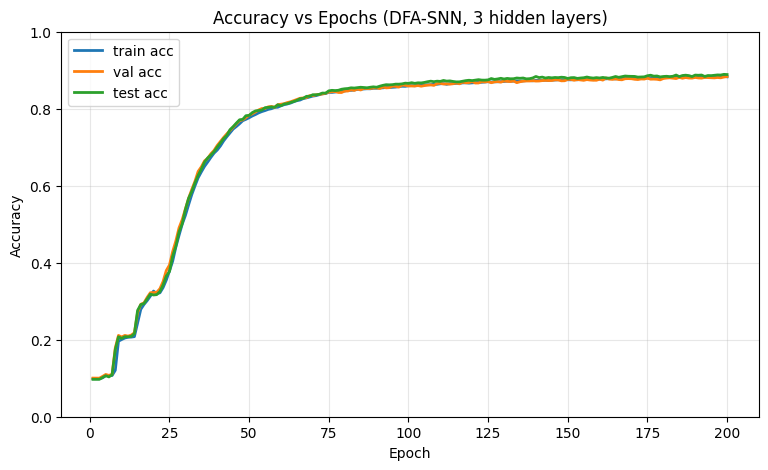

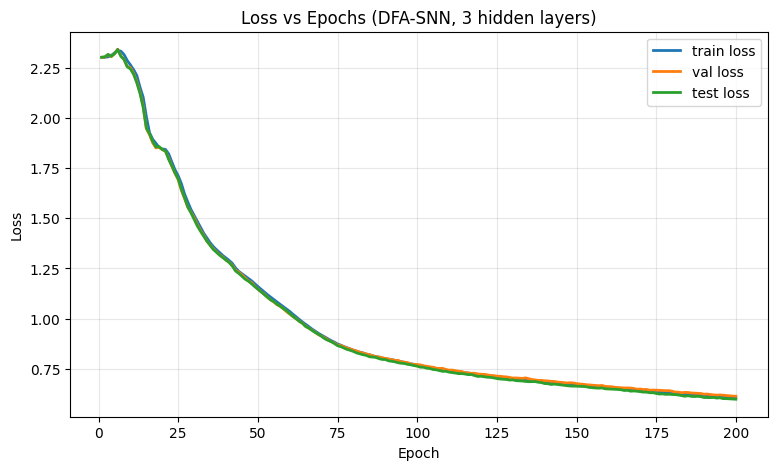

In [6]:

import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ----------------------------
# Load MNIST data (PyTorch)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),                  # -> float32 in [0,1], shape [1,28,28]
    transforms.Lambda(lambda x: x.view(-1))  # -> [784]
])

train_ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds_full  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Convert to tensors (to mirror your "x_train, y_train" arrays)
x_train = torch.stack([train_ds_full[i][0] for i in range(len(train_ds_full))]).float()  # [60000,784]
y_train_int = torch.tensor([train_ds_full[i][1] for i in range(len(train_ds_full))], dtype=torch.long)  # [60000]

x_test  = torch.stack([test_ds_full[i][0] for i in range(len(test_ds_full))]).float()    # [10000,784]
y_test_int  = torch.tensor([test_ds_full[i][1] for i in range(len(test_ds_full))], dtype=torch.long)   # [10000]

# One-hot encode labels (to match your Keras cell exactly)
y_train = F.one_hot(y_train_int, num_classes=10).float()  # [60000,10]
y_test  = F.one_hot(y_test_int,  num_classes=10).float()  # [10000,10]

print(f"Training samples: {len(x_train)}")
print(f"Test samples: {len(x_test)}")
print(f"Input shape: {x_train.shape[1]}")
print(f"Output classes: {y_train.shape[1]}")

# ----------------------------
# Hyperparams
# ----------------------------
TIME_STEPS = 25
HIDDEN_SIZE1 = 1000
HIDDEN_SIZE2 = 250
HIDDEN_SIZE3 = 100   # <-- third hidden layer ~100 neurons (as requested)
OUTPUT_SIZE = 10
INPUT_SIZE = 784

TRAIN_SAMPLES = 60000   # full dataset
VAL_FRAC = 0.10         # 10% of train used for validation

EPOCHS = 200
BATCH_SIZE = 128
EVAL_BATCH = 256

# ----------------------------
# Select subset (here: all) + expand to time dimension
# ----------------------------
x_train_small = x_train[:TRAIN_SAMPLES]          # [N,784]
y_train_small = y_train[:TRAIN_SAMPLES]          # [N,10]

# Repeat input for each time step (direct mapping)
x_train_spikes = x_train_small.unsqueeze(1).repeat(1, TIME_STEPS, 1)  # [N,T,784]

print(f"\nInput shape with time: {tuple(x_train_spikes.shape)}")
print(f"  [batch={x_train_spikes.shape[0]}, time={x_train_spikes.shape[1]}, features={x_train_spikes.shape[2]}]")

# ----------------------------
# Build DFA-SNN model (PyTorch)
# ----------------------------
print("\n" + "="*60)
print("BUILDING DFA-SNN MODEL (PyTorch)")
print("="*60)

missing = []
for name in ["DFA_LIFLayer", "DFASNN", "DFATrainerTorch"]:
    if name not in globals():
        missing.append(name)
if missing:
    raise NameError(
        "You haven't defined these yet in earlier cells: "
        + ", ".join(missing)
        + "\nRun the cells where you ported the layer/model/trainer first."
    )

# NOTE: this matches the 3-hidden-layer DFASNN signature I gave earlier:
# DFASNN(time_steps, input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
model = DFASNN(
    time_steps=TIME_STEPS,
    input_size=INPUT_SIZE,
    hidden_size1=HIDDEN_SIZE1,
    hidden_size2=HIDDEN_SIZE2,
    hidden_size3=HIDDEN_SIZE3,
    output_size=OUTPUT_SIZE
).to(device)

with torch.no_grad():
    # keep your bias init behavior; apply to the same layers that exist now
    model.hidden_layer2.b.fill_(1.0)
    model.hidden_layer3.b.fill_(1.0)
    model.output_layer.b.fill_(1.0)

print(model)

# ----------------------------
# Create DFA trainer (PyTorch)
# ----------------------------
print("\n" + "="*60)
print("INITIALIZING DFA TRAINER (PyTorch)")
print("="*60)

trainer = DFATrainerTorch(
    model=model,
    learning_rate=0.1
)

dfa_layers = []
for attr in ["hidden_layer1", "hidden_layer2", "hidden_layer3", "output_layer"]:
    if hasattr(model, attr):
        dfa_layers.append(getattr(model, attr))

print(f"\nDFA layers found: {len(dfa_layers)}")
for layer in dfa_layers:
    B_shape = tuple(layer.B.shape) if hasattr(layer, "B") else None
    print(f"  {layer.__class__.__name__}:")
    print(f"    Units: {layer.units}")
    print(f"    B shape: {B_shape}")
    print(f"    Learning rate: {trainer.lr:.6f}")

# optional debug labels
model.hidden_layer1.debug_name = "h1"
model.hidden_layer2.debug_name = "h2"
model.hidden_layer3.debug_name = "h3"
model.output_layer.debug_name = "out"

# ----------------------------
# Train/Val split
# ----------------------------
N = x_train_spikes.shape[0]
perm = torch.randperm(N)

val_n = int(N * VAL_FRAC)
val_idx = perm[:val_n]
train_idx = perm[val_n:]

x_tr = x_train_spikes[train_idx]
y_tr = y_train_small[train_idx]
x_val = x_train_spikes[val_idx]
y_val = y_train_small[val_idx]

print(f"\nTrain samples: {x_tr.shape[0]}")
print(f"Val samples:   {x_val.shape[0]}")

# ----------------------------
# Prepare test set with time dimension
# ----------------------------
x_test_spikes = x_test.unsqueeze(1).repeat(1, TIME_STEPS, 1)  # [10000,T,784]
print(f"Test spikes shape: {tuple(x_test_spikes.shape)}")

# ----------------------------
# Evaluation helper (no autograd)
# ----------------------------
@torch.no_grad()
def evaluate(model, x_time, y_onehot, batch_size=256):
    model.eval()
    n = x_time.shape[0]
    total_loss = 0.0
    total_acc = 0.0
    nb = 0
    eps = 1e-9

    for i in range(0, n, batch_size):
        xb = x_time[i:i+batch_size].to(device)
        yb = y_onehot[i:i+batch_size].to(device)

        # 3-hidden-layer forward
        h1_spikes, h2_spikes, h3_spikes, y_spikes = model(xb)

        out_rates = trainer.compute_spike_rate(y_spikes)   # [b,10]
        out_probs = F.softmax(out_rates, dim=1)

        loss = -(yb * torch.log(out_probs + eps)).sum(dim=1).mean()

        preds = torch.argmax(out_probs, dim=1)
        true  = torch.argmax(yb, dim=1)
        acc = (preds == true).float().mean().item()

        total_loss += loss.item()
        total_acc  += acc
        nb += 1

    return total_loss / nb, total_acc / nb

# ----------------------------
# Training loop with val/test each epoch
# ----------------------------
history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": [],
    "test_loss": [], "test_acc": []
}

for ep in range(EPOCHS):
    # --- train one epoch ---
    model.train()
    perm = torch.randperm(x_tr.shape[0])

    ep_loss = 0.0
    ep_acc = 0.0
    nb = 0

    for i in range(0, x_tr.shape[0], BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        loss, acc = trainer.train_step(x_tr[idx], y_tr[idx])
        ep_loss += loss
        ep_acc += acc
        nb += 1

    train_loss = ep_loss / nb
    train_acc  = ep_acc / nb

    # --- eval ---
    val_loss, val_acc = evaluate(model, x_val, y_val, batch_size=EVAL_BATCH)
    test_loss, test_acc = evaluate(model, x_test_spikes, y_test, batch_size=EVAL_BATCH)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(f"Epoch {ep+1:3d}/{EPOCHS} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
          f"test loss {test_loss:.4f} acc {test_acc:.4f}")

# ----------------------------
# Plots: Accuracy + Loss
# ----------------------------
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(9, 5))
plt.plot(epochs, history["train_acc"], linewidth=2, label="train acc")
plt.plot(epochs, history["val_acc"], linewidth=2, label="val acc")
plt.plot(epochs, history["test_acc"], linewidth=2, label="test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs (DFA-SNN, 3 hidden layers)")
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.legend()
plt.show()

plt.figure(figsize=(9, 5))
plt.plot(epochs, history["train_loss"], linewidth=2, label="train loss")
plt.plot(epochs, history["val_loss"], linewidth=2, label="val loss")
plt.plot(epochs, history["test_loss"], linewidth=2, label="test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (DFA-SNN, 3 hidden layers)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()